In [0]:
%%capture
!pip install livelossplot

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')
project_dir='/content/gdrive/My Drive/acse-miniproject/' 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
%%capture
!sudo apt-get update
!sudo apt-get install wget
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1AL0Rh5mjPgQH3pKrWqJlxVcbuAgXbON7' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1AL0Rh5mjPgQH3pKrWqJlxVcbuAgXbON7" -O data.zip && rm -rf /tmp/cookies.txt
from zipfile import ZipFile
with ZipFile('./data.zip', 'r') as zipObj:
    print("Started unzipping... \n")
    # Extract all the contents of zip file in current directory
    zipObj.extractall()
    print("Files unziped sucessfully\n")
!ls

In [5]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

from torch.optim.lr_scheduler import ReduceLROnPlateau

from livelossplot import PlotLosses
import torchvision.models

from livelossplot import PlotLosses

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [0]:
## set global hyperparameters
seed = 42
lr = 1e-2
momentum = 0.9
batch_size = 200
test_batch_size = 1000
n_epochs = 100
weight_decay = 1e-5

## calculated channel-wise mean and std of the training dataset
mean = [0.48024845, 0.44807208, 0.39754644]
std  = [0.27698642, 0.26906449, 0.28208190]

## make transforms
test_transform = transforms.Compose([#transforms.ToPILImage(),
                                     transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean, std)])

train_transform = transforms.Compose([#transforms.ToPILImage(),  
                                     transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                      # transforms.ColorJitter(brightness=(1.,1.),  # do nothing to brightness
                                                            #  contrast=(0.5, 1.5), # change contrast
                                                            #  saturation=(1.,1.),  # do nothing to saturation
                                                            #  hue=(0.,0.)),        # do nothing to hue
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)
                                    ])

In [0]:
train_data = ImageFolder('./train/', transform=train_transform)
val_data   = ImageFolder('./train/', transform=test_transform)
test_data  = ImageFolder('./test/', transform=test_transform)

shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=seed).split(np.zeros(len(train_data)),train_data.targets)
indices = [(train_idx, validation_idx)for train_idx, validation_idx in shuffler][0]
sampler_train = SubsetRandomSampler(indices[0])
sampler_val = SubsetRandomSampler(indices[1])

train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          sampler=sampler_train,
                          shuffle=False,
                          num_workers=4)

validation_loader = DataLoader(val_data,
                               batch_size=test_batch_size,
                               sampler=sampler_val,
                               shuffle=False,
                               num_workers=4)

test_loader = DataLoader(test_data,
                         batch_size=test_batch_size,
                         shuffle=False,
                         num_workers=4)

In [0]:
def mean_f1_score(true_pos, false_pos, false_neg):
    """
    Compute the mean F1-score from arrays of true positives, false positives
    and false negatives. 
    """
    all_pred_pos = true_pos + false_pos
    all_act_pos = true_pos + false_neg

    prec = np.divide(true_pos, all_pred_pos, where=(all_pred_pos != 0))
    rec = np.divide(true_pos, all_act_pos, where=(all_act_pos != 0))
    f1 = np.divide(2*prec*rec, prec+rec, where=(prec+rec != 0))

    return np.mean(f1)


def train(model, optimizer, criterion, data_loader, device):
    model.train()
    train_loss = 0.
    mcm = np.zeros((200, 2, 2))
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X)
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        mcm += multilabel_confusion_matrix(y.cpu().numpy(), y_pred.detach().cpu().numpy(), labels=list(range(200)))
        optimizer.step()

    return train_loss/len(data_loader.dataset), mean_f1_score(mcm[:, 1, 1], mcm[:, 0, 1], mcm[:, 1, 0])


def validate(model, criterion, data_loader, device):
    model.eval()
    validation_loss = 0.
    mcm = np.zeros((200, 2, 2))
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X)
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            mcm += multilabel_confusion_matrix(y.cpu().numpy(), y_pred.detach().cpu().numpy(), labels=list(range(200)))

    return validation_loss/len(data_loader.dataset), mean_f1_score(mcm[:, 1, 1], mcm[:, 0, 1], mcm[:, 1, 0])


def evaluate(model, data_loader, device):
    model.eval()
    y_preds = []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            y_preds.append(y_pred.cpu().numpy())

    return np.concatenate(y_preds, 0)

In [9]:
model = torchvision.models.resnet50(pretrained=True)

#Freezing all the layers
for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 200)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
def train_model(model, params = model.parameters(),save_path="/content/gdrive/My Drive/"):
    set_seed(seed)
    model.to(device)
    optimizer = torch.optim.SGD(params, lr=lr,momentum=momentum, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    min_loss = float("inf")
    liveloss = PlotLosses()
    for epoch in range(n_epochs):
        logs = {}
        train_loss, train_accuracy = train(model, optimizer, criterion, train_loader, device)

        logs['' + 'log loss'] = train_loss.item()
        logs['' + 'accuracy'] = train_accuracy.item()

        validation_loss, validation_accuracy = validate(model, criterion, validation_loader, device)
        logs['val_' + 'log loss'] = validation_loss.item()
        logs['val_' + 'accuracy'] = validation_accuracy.item()

        liveloss.update(logs)
        liveloss.draw()

        # Store best validation loss model
        if save_path is not None and validation_loss < min_loss:
            torch.save(model.state_dict(), save_path+F"model_state_"+str(epoch)+".pth")
            min_loss = validation_loss

    return model

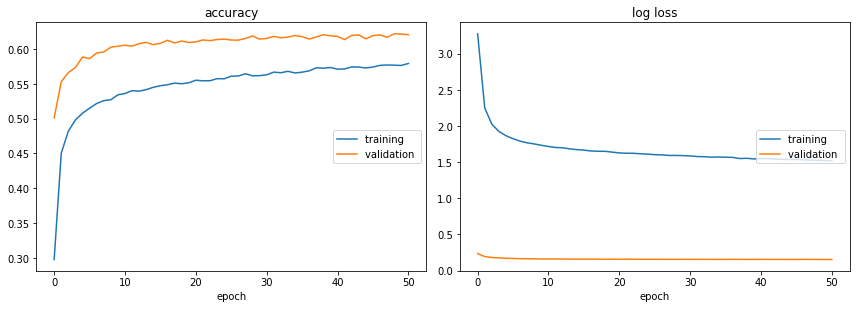

accuracy
	training         	 (min:    0.298, max:    0.579, cur:    0.579)
	validation       	 (min:    0.501, max:    0.622, cur:    0.620)
log loss
	training         	 (min:    1.518, max:    3.275, cur:    1.518)
	validation       	 (min:    0.153, max:    0.236, cur:    0.154)


In [0]:
model = train_model(model)

In [0]:
# model = models.resnet18(pretrained=True)
# model_file = project_dir + 'MODEL_FILE.pth'
# model.load_state_dict(torch.load(model_file))
# model.to(device)

prediction = evaluate(model, test_loader, device)

In [0]:
## create test prediction csv
files_list = []
file_inds = np.zeros(len(test_data), dtype=int)
for i in range(len(test_data)):
    filename = os.path.split(test_data.samples[i][0])[1]
    filename = os.path.splitext(filename)[0]
    files_list.append(filename + '.jpeg')
    file_inds[i] = int(filename[5:])

inds = file_inds.argsort()

output = np.vstack((np.array(files_list)[inds], prediction[inds])).T
output = np.vstack((['Filename','Label'], output))
np.savetxt(project_dir+'prediction.csv', output, delimiter=",", fmt=('%s','%s'))